# 이미지 식별 머신을 위한 데이터를 준비한다.

## 필요한 라이브러리를 불러 온다.

In [43]:
# 데이터 플로팅 라이브러리
import matplotlib.pyplot as plt
# 숫자 처리 라이브러리
import numpy as np
# 딥러닝을 위한 파이토치 라이브러리
import torch
from torch import nn, optim
# 토치비전 라이브러리
import torchvision
from torchvision import datasets, transforms, models
# 이미지 처리 라이브러리 (PIL, pillow)
from PIL import Image
# 주피터 노트북에서 plot이 보이도록 설정
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [44]:
#!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

## 데이터 디렉토리, 분할 비율, 변환 방법을 설정한다.

In [45]:
# 이미지 데이터가 있는 디렉토리와 데이터 세트 분할 비율(valid_size)을 정한다.
data_dir = './data'
valid_size = 0.2

# 이미지 데이터를 ResNet50에서 다룰 수 있도록 변환시키는 방법을 정한다. (t_transforms)
t_transforms = transforms.Compose([
                transforms.RandomResizedCrop(224),
                transforms.Resize(224),
                transforms.ToTensor()
])
# convert image size to 224x224 for ResNet50 after crop


### (확인) 변환 방법을 출력하여 확인해 본다.

In [46]:
# 설정한 이미지 데이터 변환 방법을 출력하여 확인한다.
print(t_transforms)

Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
    Resize(size=224, interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


## 데이터를 로딩 함수를 작성한다.

### (연습) trainloader와 testloader를 만들어 본다.

#### 1. 학습 데이터 세트 및 테스트 데이터 세트의 디렉토리 및 변환 방식을 지정한다.

In [47]:
# datasets.ImageFolder를 사용해서 학습 데이터(train_data)와 테스트 데이터(test_data)를 만든다.
# make train_data and test_data using datasets.ImageFolder
train_data = datasets.ImageFolder(data_dir, transform = t_transforms)
test_data = datasets.ImageFolder(data_dir, transform = t_transforms)


# 학습 데이터의 형식을 확인한다.
print(train_data)

# 학습 데이터와 테스트 데이터의 길이를 확인한다.
print(len(train_data), len(test_data))


Dataset ImageFolder
    Number of datapoints: 155
    Root location: ./data
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )
155 155


#### 2. 데이터세트를 섞기 위해, 우선 인덱스를 만들어 랜덤하게 섞는다.

In [48]:
# train_data 사이즈만큼의 정수값을 갖는 인덱스 리스트(indices)를 만들고 확인한다.
num_train = len(train_data)
indices = list(range(num_train))
print(indices)

# 인덱스 리스트를 랜덤하게 섞고 확인한다.
np.random.shuffle(indices)
print(indices)


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154]
[110, 21, 53, 99, 93, 117, 16, 133, 98, 147, 51, 100, 48, 68, 20, 84, 42, 39, 72, 129, 64, 116, 37, 126, 146, 89, 92, 75, 101, 12, 148, 83, 18, 112, 15, 128, 141, 85, 122, 43, 105, 49, 88, 58, 65, 80, 107, 31, 59, 50, 79, 143, 86, 25, 4, 121, 66, 26, 23, 90, 60, 149, 136, 3, 46, 95, 109, 87, 135, 8, 153, 154, 7, 140, 91, 130, 61, 67

#### 3. 분할 비율(valid_size)에 따른 지점의 인덱스 값(split)을 계산한다.

In [49]:
# 분할 비율(valid_size)에 해당하는 인덱스를 계산하고 확인해 본다.
split = int(np.floor(num_train * valid_size))
print(split)


31


#### 4. split을 기준으로 학습 데이터 인덱스 리스트와 테스트 인덱스 리스트로 나눈다.

In [50]:
# 학습 데이터 인덱스 리스트 및 테스트 인덱스 리스트를 만들고 확인해 본다.
train_idx, test_idx = indices[split:], indices[:split]

print(train_idx)
print(test_idx)


[83, 18, 112, 15, 128, 141, 85, 122, 43, 105, 49, 88, 58, 65, 80, 107, 31, 59, 50, 79, 143, 86, 25, 4, 121, 66, 26, 23, 90, 60, 149, 136, 3, 46, 95, 109, 87, 135, 8, 153, 154, 7, 140, 91, 130, 61, 67, 45, 118, 115, 144, 32, 124, 137, 63, 41, 1, 103, 142, 30, 131, 70, 113, 19, 57, 54, 152, 38, 24, 11, 139, 120, 13, 44, 73, 108, 62, 27, 10, 47, 123, 9, 28, 71, 56, 77, 14, 106, 6, 111, 2, 74, 97, 138, 0, 35, 94, 150, 134, 17, 5, 102, 96, 40, 132, 55, 34, 36, 52, 151, 114, 81, 104, 145, 22, 76, 78, 125, 29, 82, 119, 127, 33, 69]
[110, 21, 53, 99, 93, 117, 16, 133, 98, 147, 51, 100, 48, 68, 20, 84, 42, 39, 72, 129, 64, 116, 37, 126, 146, 89, 92, 75, 101, 12, 148]


#### 5. 데이터 세트들의 샘플러 및 로더를 만들고 확인한다.

In [51]:
# 데이터 샘플링 방식(SubsetRandomSampler)을 지정한다
from torch.utils.data.sampler import SubsetRandomSampler
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

# 데이터 로딩을 위한 loader를 만든다. (sampler, 배치 사이즈 등 지정)
trainloader = torch.utils.data.DataLoader(train_data, sampler = train_sampler, batch_size=16)
testloader = torch.utils.data.DataLoader(test_data, sampler = test_sampler, batch_size=16)

# 학습 loader와 테스트 loader의 class들을 출력하여 확인한다.
print(trainloader.dataset.classes)
print(testloader.dataset.classes)


['Basalt', 'Highland']
['Basalt', 'Highland']


### 코드들을 묶어서 load_split_train_test() 함수를 만든다.

In [52]:
# 위의 코드들을 묶어서 load_split_train_test() 함수를 만든다. (입력 : 데이터 디렉토리, 분할 비율) (출력 : 학습 데이터 로더, 테스트 데이터 로더)
def load_split_train_test(data_dir, valid_size):
    t_transforms = transforms.Compose([
                transforms.RandomResizedCrop(224),
                transforms.Resize(224),
                transforms.ToTensor()
    ])

    train_data = datasets.ImageFolder(data_dir, transform = t_transforms)
    test_data = datasets.ImageFolder(data_dir, transform = t_transforms)
    num_train = len(train_data)
    indices = list(range(num_train))

    np.random.shuffle(indices)
    split = int(np.floor(num_train * valid_size))
    train_idx, test_idx = indices[split:], indices[:split]

    from torch.utils.data.sampler import SubsetRandomSampler
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)

    trainloader = torch.utils.data.DataLoader(train_data, sampler = train_sampler, batch_size=16)
    testloader = torch.utils.data.DataLoader(test_data, sampler = test_sampler, batch_size=16)

    return trainloader, testloader


### load_split_train_test() 함수를 이용하여 trainloader, testloader를 생성한다.

In [53]:
# load_split_train_test() 함수를 이용하여 trainloader와 testloader를 만들고 확인한다.
trainloader, testloader = load_split_train_test(data_dir,0.2)

print(trainloader.dataset.classes)
print(testloader.dataset.classes)

['Basalt', 'Highland']
['Basalt', 'Highland']


## 이미지 데이터 샘플들을 살펴본다.

### 임의의 데이터를 로딩한 후 이미지와 레이블을 반환하는 get_random_images() 함수를 만든다.

In [54]:
def get_random_images(num):
    data= datasets.ImageFolder(data_dir, transform=t_transforms)
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]

    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, sampler=sampler, batch_size = num)
    #loader에서 데이터를 한 개씩 꺼내주는 iterator를 생성한다.
    dataiter = iter(loader)
    images, labels = next(dataiter)  

    return images, labels

### 임의 선택한 이미지를 표시해 본다.

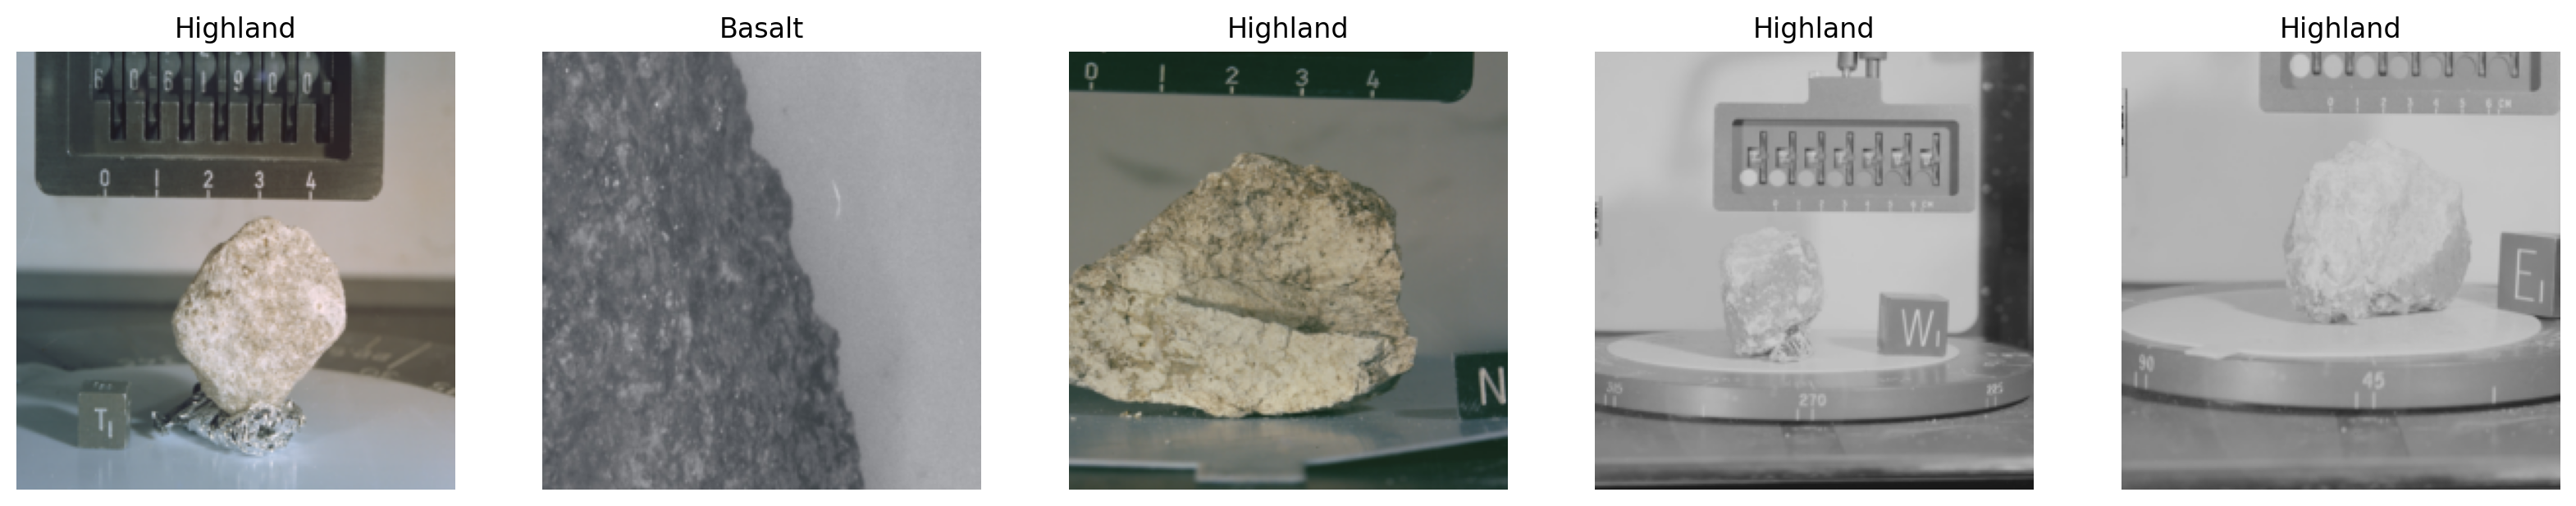

In [55]:
# 5개의 이미지와 레이블을 랜덤하게 가져온다.
images, labels = get_random_images(5)
# 픽셀 배열을 PIL 형식의 이미지로 변환하고 이미지 크기를 지정한다.
to_pil = transforms.ToPILImage()
fig = plt.figure(figsize = (20,20))

# 학습 데이터의 class 리스트를 얻는다.
classes = trainloader.dataset.classes

# 이미지를 표시하기 위한 설정을 한다.
for ii in range(len(images)):
    image = to_pil(images[ii])
    sub = fig.add_subplot(1, len(images), ii+1)
    index = labels[ii].item()
    sub.set_title(classes[index])
    plt.axis('off')
    plt.imshow(image)

# 주피터 노트북에 이미지를 표시한다.
plt.show()

# ResNet50 모델을 가져와 FCL(Fully Connected Layer)을 수정한다.

## Compute device를 정한다(CPU or GPU)

In [56]:
# compute device를 정하고 확인한다.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## 사전학습된 ResNet50 모델을 지정한다.

In [57]:
# resnet50 모델을 pretrained=True로 설정한다.
model = models.resnet50(pretrained=True)

## FCL을 수정한다.(뉴런 구축, 신경망 연결, FCL의 layer 설정 등)

In [58]:
# 모든 신경망 구축 : 전이학습을 위해 모델의 가중치를 freeze 한다.
for param in model.parameters():
    param.requires_grad = False #기존 학습한 것 사용
# 뉴런들을 연결하여 신경망을 생성한다.
model.fc = nn.Sequential(nn.Linear(2048, 512),
                         nn.ReLU(),
                         nn.Dropout(0.2),
                         nn.Linear(512, 2),
                         nn.LogSoftmax(dim=1))

# a: 2048개의 입력을 받아 512개의 출력을 내고, ReLU 함수를 거쳐 0.2의 확률로 Dropout을 적용한다.
# 512개의 입력을 받아 2개의 출력을 내고, LogSoftmax 함수를 거쳐 1차원으로 변환한다.
# 1차원으로 변환된 출력을 갖는 신경망을 생성한다.

# 손실함수를 Cross entropy loss 함수로 지정한다.
criterion =nn.NLLLoss()

# optimizer를 Adam으로 지정한다.
optimizer = optim.Adam(model.fc.parameters(), lr = 0.003)

# 신경망을 compute device로 보낸다.
model.to(device)
# 종료 여부를 출력한다.
print('done!')


done!


### (확인) FCL을 확인해 본다.

In [59]:
print(model.fc)

Sequential(
  (0): Linear(in_features=2048, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=512, out_features=2, bias=True)
  (4): LogSoftmax(dim=1)
)


# 모델의 FCL을 학습시키고 테스트 한다.

## 모델 학습/검증을 위한 변수를 설정한다.

In [60]:
# 에폭 및 출력 간격을 설정한다.
epochs = 10
print_every = 5
# 손실 변수들을 초기화 한다.
running_loss = 0
train_losses, test_losses = [], []
# 현재의 학습 단계를 표현하는 steps 변수를 0으로 초기화 한다.
steps = 0


## 설정한 에폭만큼 모델을 학습시키며 검증/평가 한다.

In [61]:
# 설정한 횟수만큼 학습 후 테스트 및 평가해 본다.
import time
start_time = time.time()

for epoch in range(epochs):
    #에폭을 count한다.
    epoch += 1
    # trainloader로부터 모든 이미지와 레이블을 로드한다.
    for inputs, labels in trainloader:
        #학습 단계를 count 하고 출력한다.
        steps += 1
        print('Training step', steps)
        #입력 데이터(이미지, 레이블)를 device로 보낸다.
        inputs, labels = inputs.to(device), labels.to(device)
        #기존에 학습된 gradient 값을 초기화한다.(이전에 학습한 값이 영향을 주지 않도록 함)
        optimizer.zero_grad()
        #입력 데이터로 순전파를 수행하고 로그 확률을 얻는다.
        logps = model.forward(inputs)
        #손실(loss) 값들을 계산한다.
        loss = criterion(logps, labels)
        #손실값을 이용하여 gradient를 update한다
        loss.backward()
        # gradient를 이용하여 설정된 optimizer로 파라미터를 update한다.
        optimizer.step()
        #손실값을 누적/계산한다.
        running_loss += loss.item()
        #학습단계 5회마다 모델을 데스트/평가한다.
        if steps % print_every == 0:
            #손실과 정확도 변수를 초기화한다.
            test_loss = 0
            accuracy = 0
            #모델 평가 모드로 전환한다.
            model.eval()
            #모델 평가 시 gradient를 계산하지 않도록 한다.
            with torch.no_grad():
                #testloader로부터 모든 이미지와 레이블을 로드한다.
                for inputs, labels in testloader:
                    #입력데이터(이미지, 레이블)를 device로 보낸다.
                    inputs, labels = inputs.to(device), labels.to(device)
                    #입력 데이터로 순전파를 수행하고 로그 확률을 얻는다.
                    logps = model.forward(inputs)
                    #손실(loss) 값들을 계산한다.
                    batch_loss = criterion(logps, labels)
                    #손실값을 누적시킨다.
                    test_loss += batch_loss.item()
                    #로그 확률로부터 진짜 확률값을 계산한다.
                    ps = torch.exp(logps)
                    #가장 큰 확률값과 class를 얻는다.(topk: k번째로 큰 값)
                    top_p, top_class = ps.topk(1, dim = 1)
                    #레이블들을 top_class와 동일한 현태로 바꾼 후 같은 값들을 얻는다.
                    equals = top_class == labels.view(*top_class.shape)
                    #equals를 float 텐서로 바꾼 후 평균 정확도를 누적/계산한다.
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            #학습 손실값과 테스트 손실값을 추가한다.
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))
            #학습 손실값, 테스트 손실값, 테스트 정확도를 출력한다.
            print("Epoch {}/{} : ".format(epoch, epochs),
                  "Train loss: {:3f}.. ".format(running_loss/print_every),
                  "Test loss: {:.3f}.. ".format(test_loss/len(testloader)),
                  "Test accuracy: {:.3f}\n".format(accuracy/len(testloader)))
            #running_loss 값을 초기화한다.
            running_loss = 0
            #모델을 학습 모드로 전환한다.
            model.train()
            break
duration = time.time() - start_time
print(f"Process took {duration} seconds")

Training step 1
Training step 2
Training step 3
Training step 4
Training step 5
Epoch 1/10 :  Train loss: 2.076906..  Test loss: 1.743..  Test accuracy: 0.552

Training step 6
Training step 7
Training step 8
Training step 9
Training step 10
Epoch 2/10 :  Train loss: 0.977155..  Test loss: 0.554..  Test accuracy: 0.675

Training step 11
Training step 12
Training step 13
Training step 14
Training step 15
Epoch 3/10 :  Train loss: 0.435751..  Test loss: 0.435..  Test accuracy: 0.842

Training step 16
Training step 17
Training step 18
Training step 19
Training step 20
Epoch 4/10 :  Train loss: 0.316437..  Test loss: 0.364..  Test accuracy: 0.806

Training step 21
Training step 22
Training step 23
Training step 24
Training step 25
Epoch 5/10 :  Train loss: 0.447244..  Test loss: 0.322..  Test accuracy: 0.840

Training step 26
Training step 27
Training step 28
Training step 29
Training step 30
Epoch 6/10 :  Train loss: 0.364239..  Test loss: 0.284..  Test accuracy: 0.838

Training step 31
Tr

### (확인) 학습 손실값과 테스트 손실값을 그래프로 확인한다.

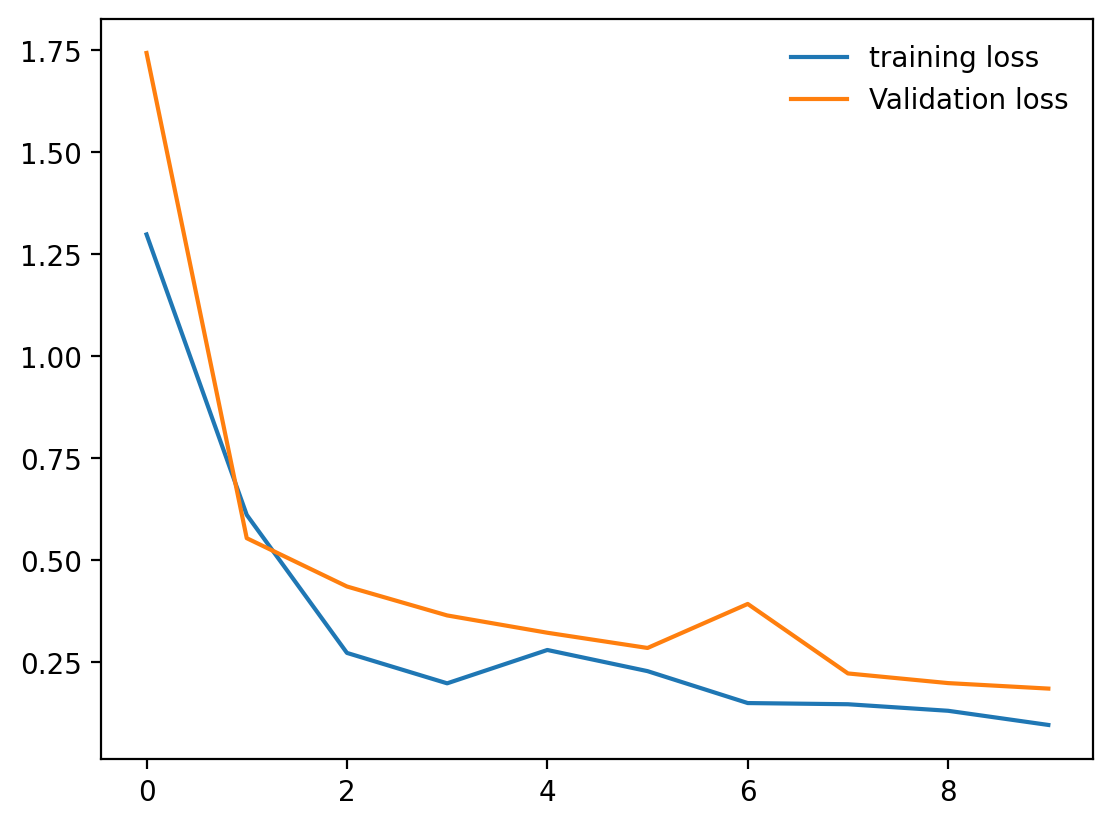

In [62]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
# in this graph, what is x-axis? y-axis?
# x-axis: epoch
# y-axis: loss

# 학습/테스트 완료된 모델을 저장한다.

In [63]:
# 추후 로드하여 사용할 수 있도록 학습/테스트 완료된 모델을 저장한다.
torch.save(model, 'moonrockmodel.pth')

# 완성된 모델을 사용하여 예측한다.

## 저장한 모델을 불러온다.

In [64]:
# 저장한 모델을 불러온다.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.load('moonrockmodel.pth')

C:\Users\USER\AppData\Local\Temp\ipykernel_15236\2909459748.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('moonrockmodel.pth')


### (확인) 불러온 모델을 확인해 본다.

In [65]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## 이미지 예측을 위해 predict_image() 함수를 만든다.

In [81]:
def predict_image(image):
    image_tensor = t_transforms(image).float()
    input = image_tensor.unsqueeze_(0)
    input = input.to(device)
    output = model(input)
    #index = output.data.numpy().argmax()
    #value, index = torch.max(output,1)
    index = output.cpu().data.numpy().argmax()

    return index

## 5개의 이미지를 임의로 가져와 예측해 본다.

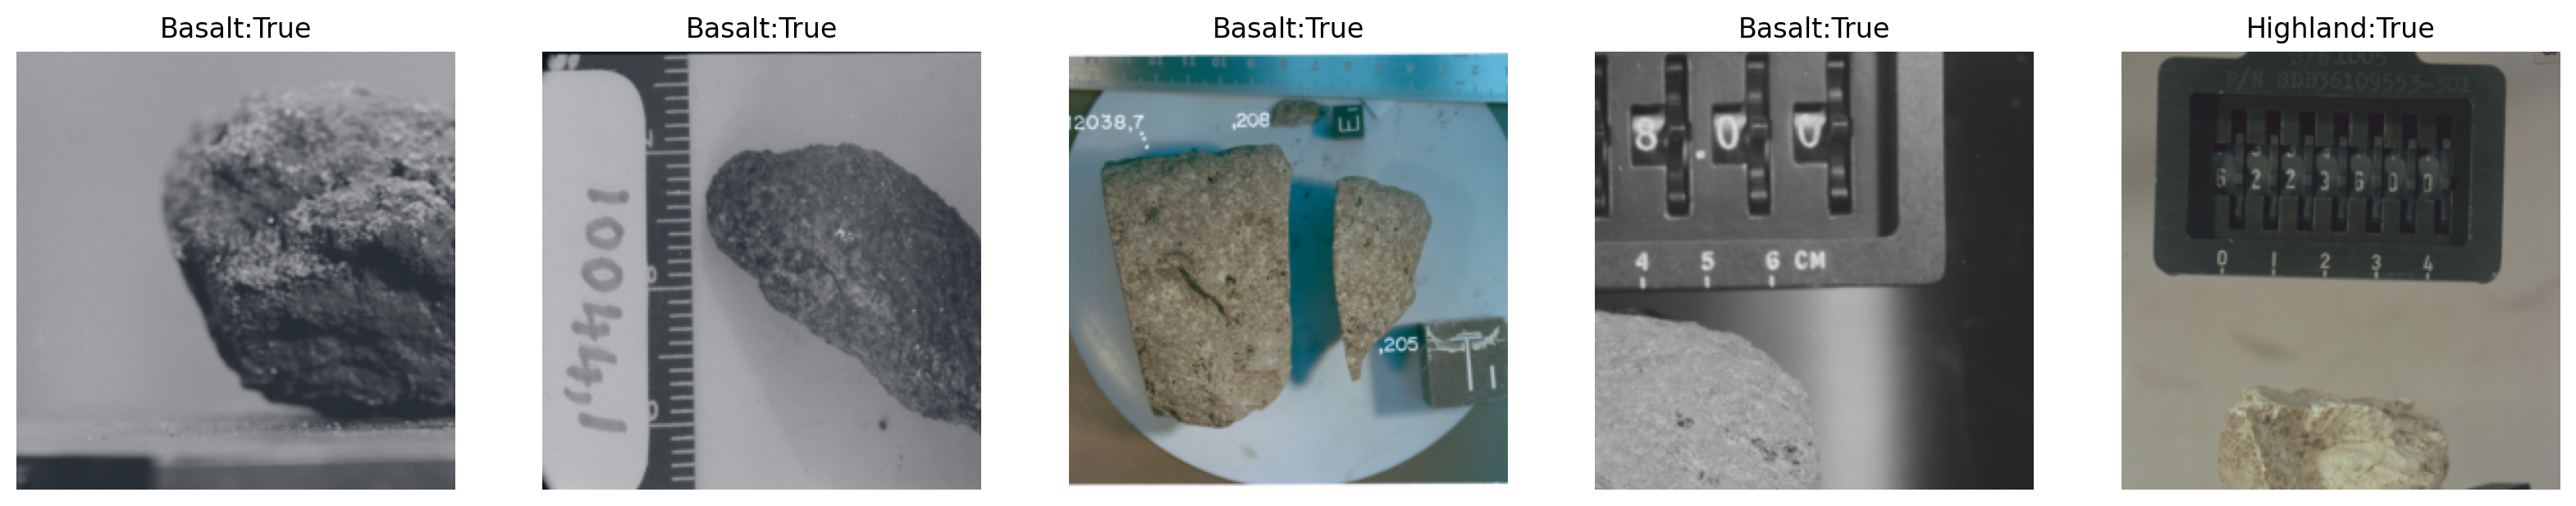

In [82]:
# 모델 평가 모드로 전환한다.
model.eval()

# 5개의 이미지와 레이블을 랜덤하게 가져온 후 PIL 형식 변환, 표시할 이미지 크기를 설정한다.
to_pil = transforms.ToPILImage()
images, labels = get_random_images(5)
fig = plt.figure(figsize = (20,20))

# 학습 데이터의 class 리스트를 얻는다.
classes = trainloader.dataset.classes

# 5개의 이미지에 대해 loop를 수행한다.
for ii in range(len(images)):
    # 각 이미지에 대해 class를 예측한다.
    image = to_pil(images[ii])
    index = predict_image(image)
    # image아래에 class를 표시하도록 설정한다.
    sub = fig.add_subplot(1, len(images), ii+1)
    res = labels[ii].item() == index
    sub.set_title(classes[index] + ':' + str(res))
    plt.axis('off')
    plt.imshow(image)

# 레이블이 추가된 이미지를 보여준다.
plt.show()